In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import math
from typing import Callable, Tuple, List

# Langrange interpolation

In [2]:
def lagrange_polynomial(x_values:np.ndarray, y_values:np.ndarray) -> sp.Expr:
    n = len(x_values)
    x = sp.symbols('x')
    polynomial = 0
    for i in range(n):
        L = 1
        for j in range(n):
            if i != j:
                L *= (x - x_values[j])/(x_values[i] - x_values[j])
        polynomial += y_values[i] * L
    return polynomial

## Tests for Lagrange interpolation method

In [3]:
x = np.array([-1, 0, 2], np.float64)
y = np.array([4, 1, -1], np.float64)

polynomial = lagrange_polynomial(x, y)
polynomial.simplify()

0.666666666666667*x**2 - 2.33333333333333*x + 1.0

# Newton interpolation

In [4]:
def divided_difference(x_values:np.ndarray, y_values:np.ndarray) -> sp.Expr:
    n = len(x_values)
    if n == 1:
        return y_values[0]
    return (divided_difference(x_values[1:], y_values[1:]) - divided_difference(x_values[:-1], y_values[:-1]))/(x_values[-1] - x_values[0])

def newton_interpolation(x_values:np.ndarray, y_values:np.ndarray) -> sp.Expr:
    n = len(x_values)
    x = sp.symbols('x')
    polynomial = y_values[0]
    for i in range(1, n):
        L = 1
        for j in range(i):
            L *= (x - x_values[j])
        polynomial += L * divided_difference(x_values[:i+1], y_values[:i+1])
    return polynomial


# Tests for Newton interpolation

In [5]:
x = np.array([-1, 0, 2], np.float64)
y = np.array([4, 1, -1], np.float64)

polynomial = newton_interpolation(x, y)
polynomial.simplify()

0.666666666666667*x**2 - 2.33333333333333*x + 1.0

# Splines

In [6]:
class Spline:
    def __init__(self):
        self.curves = []
        
    def add_curve(self, curve : Callable[[float], float], x_lim_inf : float, x_lim_sup : float):
        left = 0
        right = len(self.curves) - 1
        while left <= right:
            mid = left + (right - left) // 2
            if self.curves[mid]['x_lim_inf'] == x_lim_inf:
                raise ValueError('A curve with the same x_lim_inf already exists')
            elif self.curves[mid]['x_lim_inf'] < x_lim_inf:
                left = mid + 1
            else:
                right = mid - 1

        self.curves.insert(left, {'curve': curve, 'x_lim_inf': x_lim_inf, 'x_lim_sup': x_lim_sup})

    def evaluate(self, x : float) -> float:
        # Find the curve that contains x by doing a binary search
        # if no such curve exists it will raise an error

        left = 0
        right = len(self.curves) - 1

        while left <= right:
            mid = left + (right - left) // 2
            if self.curves[mid]['x_lim_inf'] <= x <= self.curves[mid]['x_lim_sup']:
                # return self.curves[mid]['curve'].subs('x', x)
                return self.curves[mid]['curve'](x)
            elif self.curves[mid]['x_lim_inf'] < x:
                left = mid + 1
            else:
                right = mid - 1

        raise ValueError('No curve found for x')

In [7]:
x_values = np.array([1, 2, 5, 7], np.float64)
y_values = np.array([1, 2, 3, 25], np.float64)

n = len(x_values)

spline = Spline()

for i in range(n - 1):
    x0, x1 = x_values[i], x_values[i + 1]
    y0, y1 = y_values[i], y_values[i + 1]
    curve = lambda x, x0=x0, x1=x1, y0=y0, y1=y1: y0 + (y1 - y0)/(x1 - x0) * (x - x0)
    spline.add_curve(curve, x0, x1)

spline.evaluate(7)

25.0

In [8]:
def cubic_natural_curve(x_values:np.ndarray, y_values:np.ndarray) -> List[Callable[[float], float]]:
    n = len(x_values)
    h = x_values[1] - x_values[0]
    a = y_values[0]
    b = (y_values[1] - y_values[0])/h
    c = 0
    d = 0
    curves = []

    # First curve is a special case, it's a linear curve
    curve = lambda x, a=a, b=b, x0=x_values[0]: a + b * (x - x0)
    curves.append(curve)

    for i in range(1, n - 1):
        h = x_values[i] - x_values[i - 1]
        a = y_values[i - 1]
        b = (y_values[i] - y_values[i - 1])/h
        c = (y_values[i - 1] - 2 * y_values[i] + y_values[i + 1])/h**2
        d = (y_values[i] - y_values[i - 1])/(h**3)
        curve = lambda x, a=a, b=b, c=c, d=d, x0=x_values[i]: a + b * (x - x0) + c * (x - x0)**2 + d * (x - x0)**3
        curves.append(curve)
    return curves

In [9]:
x_values = np.array([3, 4.5, 7, 9], np.float64)
y_values = np.array([2.5, 1.0, 2.5, 0.5], np.float64)

curves = cubic_natural_curve(x_values, y_values)

spline = Spline()

for i, curve in enumerate(curves):
    spline.add_curve(curve, x_values[i], x_values[i + 1])

spline.evaluate(4.5)

2.5

# Function adjustment

In [10]:
def linear_regression(x_values:np.ndarray, y_values:np.ndarray) -> Callable[[float], float]:
    x_mean = np.mean(x_values)
    y_mean = np.mean(y_values)
    x_diff = x_values - x_mean
    y_diff = y_values - y_mean
    m = np.sum(x_diff * y_diff)/np.sum(x_diff**2)
    c = y_mean - m * x_mean
    return lambda x, m=m, c=c: m * x + c

In [11]:
def exponential_regression(x_values:np.ndarray, y_values:np.ndarray, 
                          x_fun: Callable[[float], float] = lambda x: x,
                          y_fun: Callable[[float], float] = lambda y: y,
                          a_fun: Callable[[float], float] = lambda a: a, 
                          b_fun: Callable[[float], float] = lambda b: b) -> Callable[[float], float]:
    x_values = x_fun(x_values)
    y_values = y_fun(y_values)

    x_sum = np.sum(x_values)
    y_sum = np.sum(y_values)
    x_times_y_sum = np.sum(x_values * y_values)
    x_squared_sum = np.sum(x_values**2)

    a = (len(x_values) * x_times_y_sum - x_sum * y_sum)/(len(x_values) * x_squared_sum - x_sum**2)
    b = (y_sum - a * x_sum)/len(x_values)

    return (a_fun(a), b_fun(b))

In [12]:
x_values = np.array([1, 2, 3, 4], np.float64)
y_values = np.array([3, 5, 6, 8], np.float64)

identity_function = lambda x: x
a, b = exponential_regression(x_values, y_values, identity_function, np.log, identity_function, np.exp)

# y = b * exp(a * x)

y = lambda x, a=a, b=b: b * np.exp(a * x)

y(2.6)

5.344462061821694

# Exercises

# 1 - A car traveled between two cities that are 160 Km apart in 2h20min. The values below have the time and distance traveled in discrete intervals.

In [13]:
time = np.array([0, 10, 30, 60, 90, 120, 140], np.float64)
distance = np.array([0, 8, 27, 58, 100, 145, 160], np.float64)

## a) What was the approximate traveled distance by the car in the first 45 minutes considering only the first 4 points

In [31]:
l_pol = lagrange_polynomial(time[:4], distance[:4])
n_pol = newton_interpolation(time[:4], distance[:4])

l_result = l_pol.subs('x', 45)
n_result = n_pol.subs('x', 45)

# Results are the same
assert l_result - n_result < 1e-10

l_result

42.5625000000000

The results are the same, as they should be and the result is inside the interval expected

$ x \in [30; 60] $

$ y \in [27; 58] $

$ g(45) = 42.5625 $

## b) How long the car took to arrive at half the destination

To obtain the time, the values inputed for both $x$ and $y$ are inverted, the $x$ values will be the traveled distance and the $y$ values will be the time 

In [32]:
half_destination = distance[-1] / 2

l_pol = lagrange_polynomial(distance, time)
n_pol = lagrange_polynomial(distance, time)

l_result = l_pol.subs('x', half_destination)
n_result = n_pol.subs('x', half_destination)

# Results are equal within a 1/(10^10) error
assert l_result - n_result < 1e-10

n_result

77.8354988011719

The obtained result is inside the value expected. For traveling 80Km, the car took approximately 78 minutes.

# 2 - A wire has the following resistivity (Ohms) according to the lenght (m)

In [33]:
lenght = np.array([500, 1000, 1500, 2000, 2500, 3000, 3500, 4000], np.float64)
resistivity = np.array([2.74, 5.48, 7.90, 11.00, 13.93, 16.43, 20.24, 23.52], np.float64)

Using polinommyals of degree 2 and 3, calculate the aproximation to the risistivity in with the given lenght

## a) 1730m

First using a degree 2 polinomyal using 3 points, $ [1000, 1500, 2000] $

In [34]:
l_pol = lagrange_polynomial(lenght[1:4], resistivity[1:4])
n_pol = newton_interpolation(lenght[1:4], resistivity[1:4])

l_result = l_pol.subs('x', 1730)
n_result = n_pol.subs('x', 1730)

# Results are the same
assert l_result - n_result < 1e-10

l_result

9.24154400000000

Now using the degree 3 polinomyal, using 4 points $ [500, 1000, 1500, 2000] $

In [35]:
l_pol = lagrange_polynomial(lenght[:4], resistivity[:4])
n_pol = newton_interpolation(lenght[:4], resistivity[:4])

l_result = l_pol.subs('x', 1730)
n_result = n_pol.subs('x', 1730)

# Results are the same
assert l_result - n_result < 1e-10

l_result

9.18110000000000

In both cases the result is inside the interval expected for the input value, the result should be between $[7.9; 11.0]$ as the input is between $[1500; 2000]$

## b) 3200m

Solving using the degree 2 polynomial considering the 3 points $[2500, 3000, 3500]$

In [36]:
l_pol = lagrange_polynomial(lenght[4:7], resistivity[4:7])
n_pol = newton_interpolation(lenght[4:7], resistivity[4:7])

l_result = l_pol.subs('x', 3200)
n_result = n_pol.subs('x', 3200)

# Results are the same
assert l_result - n_result < 1e-10

l_result

17.7968000000000

Result is inside the expected range for the input $[16.43;20.24]$

Now calculating using the degree 3 polynomial, considering the points $[2500, 3000, 3500, 4000]$

In [37]:
l_pol = lagrange_polynomial(lenght[4:], resistivity[4:])
n_pol = newton_interpolation(lenght[4:], resistivity[4:])

l_result = l_pol.subs('x', 3200)
n_result = n_pol.subs('x', 3200)

# Results are the same
assert l_result - n_result < 1e-10

l_result

17.8998400000000

The result found is inside the expected interval using a degree 3 polynomial to interpolate the points

# 3 -

# 4 - The number of bacteria by unit of volume is given in by hours 

In [38]:
hours = np.array([0, 1, 2, 3, 4, 5, 6], np.float64)
number_of_bacteria = np.array([32, 47, 65, 92, 132, 190, 275], np.float64)

## a) Make the scatter plot of the data

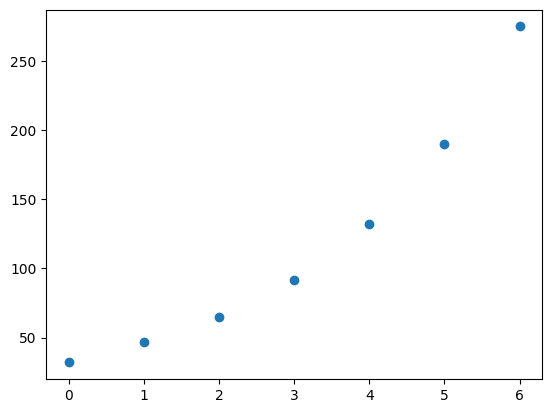

In [39]:
plt.scatter(hours, number_of_bacteria)
plt.show()

By analizing the scatter plot, the values appear to show an exponential form

## b) Use the function adjustment to adjust the curves $ y = ab^x $ and $y=ax^b$

$y = ab^x$

In [71]:
i = lambda v : v
a, b = exponential_regression(
  x_values=hours, 
  y_values=number_of_bacteria,
  x_fun=i,
  y_fun=np.log,
  a_fun=np.exp,
  b_fun=np.exp
  )

# g(x) = b * a ^ x
y = lambda x, a=a, b=b: b * np.power(a, x)

list(map(y, hours))

[32.1468513163175,
 45.87223257677207,
 65.45778623455297,
 93.40556450043047,
 133.2858928100849,
 190.193478484888,
 271.3982590019799]

$ y = ax^b$

In [77]:
#g(x) = b *  x^a
i = lambda v : v
a, b = exponential_regression(
  x_values=hours[1:], 
  y_values=number_of_bacteria[1:],
  x_fun=np.log,
  y_fun=np.log,
  a_fun=np.exp,
  b_fun=i
  )

# g(x) = b * a ^ x
y = lambda x, a=a, b=b: b * np.power(x, a)

list(map(y, hours[1:]))

[3.659417456986258,
 22.49285662413486,
 65.06765383927083,
 138.2538628239886,
 248.06202462177376,
 399.94273019642884]

In [78]:
#g(x) = b *  x^a

# certa
i = lambda v : v
a, b = exponential_regression(
  x_values=hours, 
  y_values=number_of_bacteria,
  x_fun=i,
  y_fun=np.log,
  a_fun=np.exp,
  b_fun=np.exp
  )

# g(x) = b * a ^ x
y = lambda x, a=a, b=b: b * np.power(x, a)

list(map(y, hours))

[0.0,
 32.1468513163175,
 86.43623564101127,
 154.15968619061968,
 232.40916375521013,
 319.5507524307597,
 414.50351795894517]